<a href="https://colab.research.google.com/github/clearlakerabbit/ME793_Project/blob/main/ME793_simulation_trajectory_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
try:
    import casadi
except:
    !pip install casadi
    import casadi

try:
    import do_mpc
except:
    !pip install do_mpc
    import do_mpc

try:
    import pybounds
except:
    #!pip install pybounds
    !pip install git+https://github.com/vanbreugel-lab/pybounds
    import pybounds

Noisy measurements created. Ready for EKF estimation.


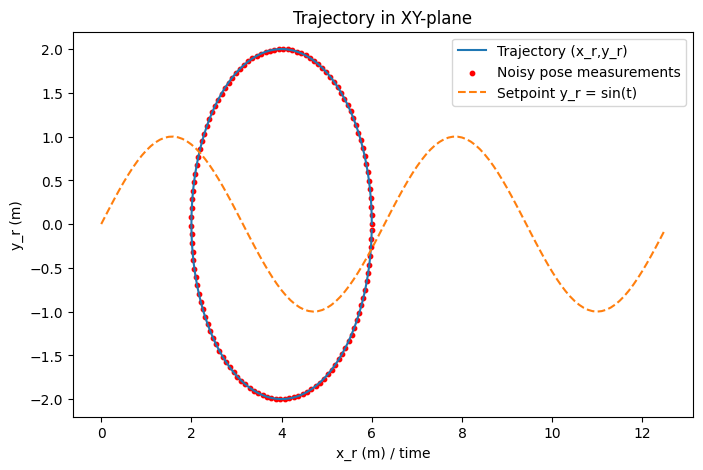

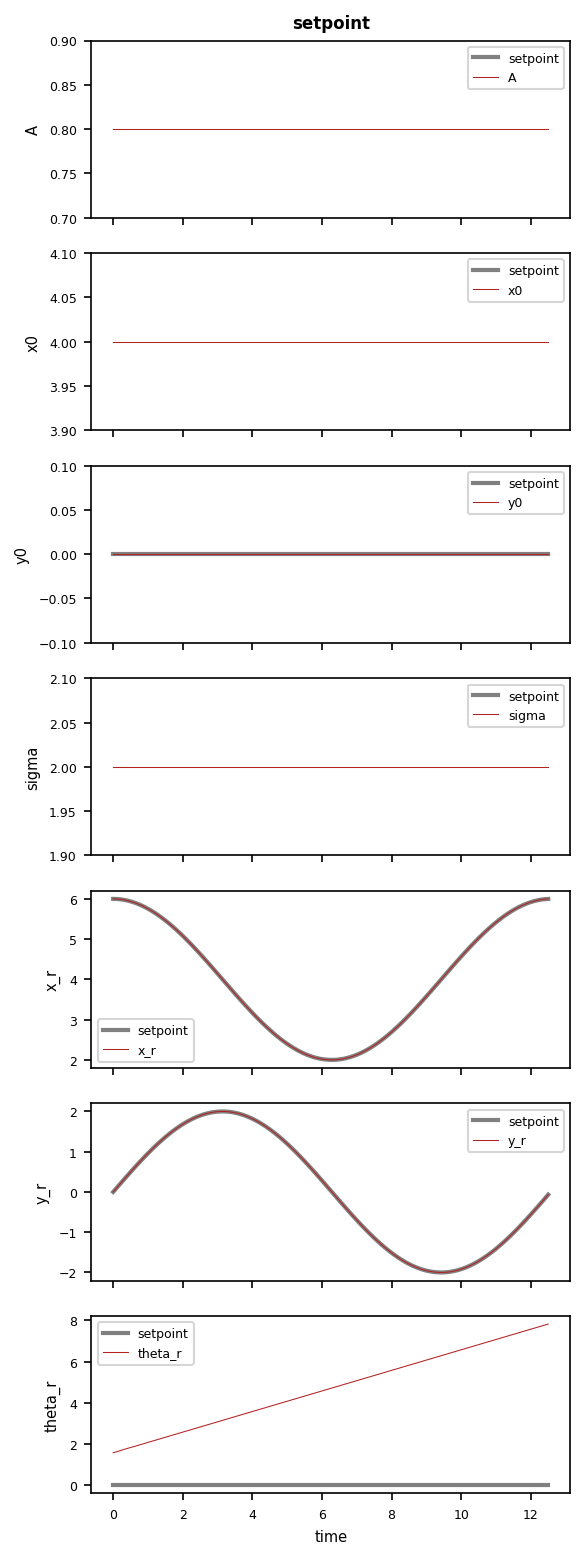

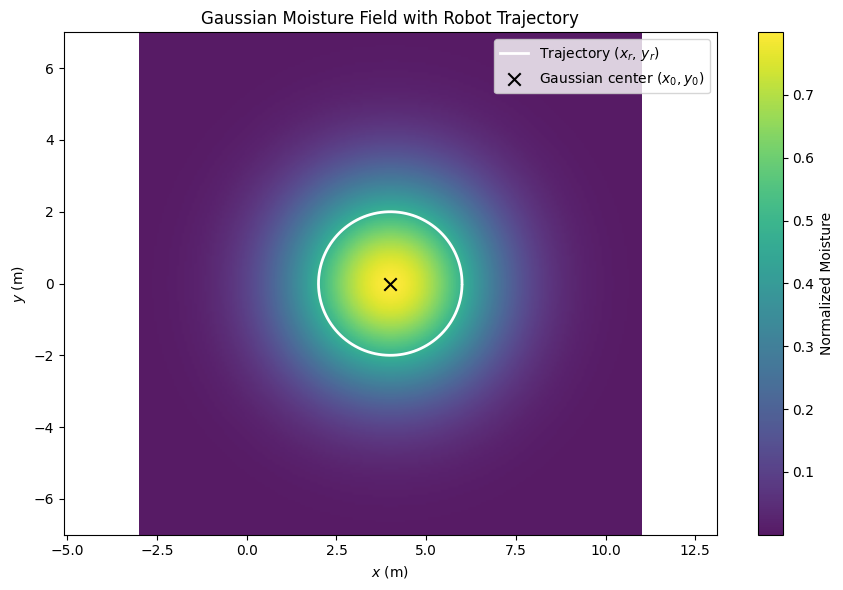

In [15]:
import pybounds
import numpy as np
import matplotlib.pyplot as plt

#parameters
params = dict(
    # Robot physical params
    m=20.0, kv=300.0, bv=20.0, Iz=1.0, kw=50.0, bw=2.0,
    # field parameters (real, for purposes of simulation)
    A_true=0.8, x0_true=4.0, y0_true=0.0, sigma_true=2.0,
    soil_type=1.0, # example scalar representing soil type
    force_alpha=500.0, # scaling for force model
    force_beta=200.0, # nonlinear term for force model
    # measurement noise (stddev)
    noise_pose_xy=0.2,
    noise_pose_theta=0.05,
    noise_moisture=0.02,
    noise_force=0.4
)

# dynamics
# dynamics
def f(x, u):
    if x is None:
        return None
    if u is None:
        u = [0.0, 0.0]

    v, w = u

    # unpack state
    A, x0, y0, sigma, x_r, y_r, theta_r = x

    # static field parameters
    dA = 0.0
    dx0 = 0.0
    dy0 = 0.0
    dsigma = 0.0

    # simple unicycle kinematics for robot pose
    dx_r = v * np.cos(theta_r)
    dy_r = v * np.sin(theta_r)
    dtheta = w

    return np.array([dA, dx0, dy0, dsigma, dx_r, dy_r, dtheta])  # Changed from list to np.array

# measurement model
def g_m_from_state(x):
    # return moisture value m = Gaussian(A, x0, y0, sigma) evaluated at robot pose (x_r,y_r)
    A, x0, y0, sigma, x_r, y_r, theta_r = x
    sigma_eff = sigma if sigma > 1e-6 else 1e-6
    m_val = A * np.exp(-((x_r - x0)**2 + (y_r - y0)**2) / (2.0 * sigma_eff**2))
    return m_val

def force_model(m_local, soil_type=params['soil_type']):
    alpha = params['force_alpha']
    beta = params['force_beta']
    F = soil_type * (alpha * (1.0 - m_local) + beta * (1.0 - m_local)**2)
    return F

# measurement model
def h(x, u):
    if x is None:
        return None

    # unpack state
    A, x0, y0, sigma, x_r, y_r, theta_r = x

    # pose measurements with additive Gaussian noise
    x_r_meas = x_r
    y_r_meas = y_r
    theta_meas = theta_r

    # environmental measurements
    m_local = g_m_from_state(x)
    z_m = m_local

    # force measurement (nonlinear) + noise
    z_f = force_model(m_local)

    return np.array([x_r_meas, y_r_meas, theta_meas, z_m, z_f])  # Changed from list to np.array

state_names = ['A', 'x0', 'y0', 'sigma', 'x_r', 'y_r', 'theta_r']
input_names = ['v', 'w']
measurement_names = ['x_r', 'y_r', 'theta_r', 'z_m', 'z_f']
dt = 0.1
tsim = np.arange(0, 12.6, step=dt)

# create simulator
simulator = pybounds.Simulator(f, h, dt=dt, state_names=state_names,
                               input_names=input_names, measurement_names=measurement_names,
                               mpc_horizon=10)

r = 2.0
cx, cy = 4.0, 0.0
omega = 0.5

# true initial states
# x0 = [
#     params['A_true'],
#     params['x0_true'],
#     params['y0_true'],
#     params['sigma_true'],
#     2.5, # x_r initial
#     -2.0, # y_r initial
#     0.0 # theta_r initial
# ]

x0 = [
    params['A_true'],
    params['x0_true'],
    params['y0_true'],
    params['sigma_true'],
    4.0 + r,   # x_r initial (rightmost point on circle)
    0.0,       # y_r initial
    np.pi / 2  # theta_r initial (facing upward, tangent to circle)
]

# # setpoint/time-varying params
# setpoint = {
#     'x_r': tsim,
#     'y_r': np.sin(tsim),
# }

# setpoint/time-varying params
setpoint = {
    'x_r': cx + r * np.cos(omega * tsim),
    'y_r': cy + r * np.sin(omega * tsim),
}
simulator.update_dict(setpoint, name='setpoint')

# objective function
cost_x = (simulator.model.x['x_r'] - simulator.model.tvp['x_r_set']) ** 2
cost_y = (simulator.model.x['y_r'] - simulator.model.tvp['y_r_set']) ** 2
cost = cost_x + cost_y
simulator.mpc.set_objective(mterm=cost, lterm=cost)

simulator.mpc.set_rterm(v=1e-4, w=1e-4)

# input bounds
simulator.mpc.bounds['upper', '_u', 'v'] = 1.5
simulator.mpc.bounds['lower', '_u', 'v'] = -1.5
simulator.mpc.bounds['upper', '_u', 'w'] = 0.8
simulator.mpc.bounds['lower', '_u', 'w'] = -0.8

# simulator
t_sim, x_sim, u_sim, y_sim = simulator.simulate(x0=x0, u=None, mpc=True, return_full_output=True)

# Add measurement noise to create noisy observations for EKF
measurement_noise_stds = {
    'x_r': params['noise_pose_xy'],
    'y_r': params['noise_pose_xy'],
    'theta_r': params['noise_pose_theta'],
    'z_m': params['noise_moisture'],
    'z_f': params['noise_force'],
}

# Create noisy measurements by adding Gaussian noise
y_noisy = {key: y_sim[key] + np.random.normal(0, measurement_noise_stds[key], len(y_sim[key]))
           for key in y_sim.keys()}

# Convert to dataframes for EKF
y_noisy_df = pd.DataFrame(y_noisy)
u_sim_df = pd.DataFrame(u_sim)
x_sim_df = pd.DataFrame(x_sim)

print("Noisy measurements created. Ready for EKF estimation.")

# plot trajectory and measurements
plt.figure(figsize=(8, 5))
plt.plot(x_sim['x_r'], x_sim['y_r'], label='Trajectory (x_r,y_r)')
plt.scatter(y_sim['x_r'], y_sim['y_r'], color='red', s=10, label='Noisy pose measurements')
plt.plot(tsim, np.sin(tsim), '--', label='Setpoint y_r = sin(t)')
plt.xlabel('x_r (m) / time')
plt.ylabel('y_r (m)')
plt.title('Trajectory in XY-plane')
plt.legend()
simulator.plot('setpoint')
plt.tight_layout()
plt.show()

xr_traj = np.array(x_sim['x_r'])
yr_traj = np.array(x_sim['y_r'])

# padding for trajectory + Gaussian center
pad_x = 1.0
pad_y = 1.0

xmin = min(xr_traj.min(), params['x0_true'] - 3*params['sigma_true']) - pad_x
xmax = max(xr_traj.max(), params['x0_true'] + 3*params['sigma_true']) + pad_x
ymin = min(yr_traj.min(), params['y0_true'] - 3*params['sigma_true']) - pad_y
ymax = max(yr_traj.max(), params['y0_true'] + 3*params['sigma_true']) + pad_y

# grid for moisture field
nx, ny = 200, 200
x = np.linspace(xmin, xmax, nx)
y = np.linspace(ymin, ymax, ny)
X, Y = np.meshgrid(x, y)

# Gaussian moisture field (ground truth) with previously set params
A_true = params['A_true']
x0_true = params['x0_true']
y0_true = params['y0_true']
sigma_true = params['sigma_true']
Z = A_true * np.exp(-((X - x0_true)**2 + (Y - y0_true)**2) / (2 * sigma_true**2))

# start plotting
plt.figure(figsize=(9, 6))

# show moisture map first
im = plt.imshow(Z,
                extent=[xmin, xmax, ymin, ymax],
                origin='lower',
                cmap='viridis',
                alpha=0.9,
                aspect='auto')

# plot planned setpoint path
try:
    if 'x_r' in simulator.model.tvp and 'y_r' in simulator.model.tvp:
        plt.plot(simulator.model.tvp['x_r_set'], simulator.model.tvp['y_r_set'], 'k--', alpha=0.6, label='Setpoint path')
except Exception:
    pass

# robot trajectory and noisy pose measurements on top
plt.plot(xr_traj, yr_traj, color='white', linewidth=2, label='Trajectory ($x_r$, $y_r$)')
# plt.scatter(y_sim['x_r'], y_sim['y_r'], color='red', s=12, label='Noisy pose measurements', zorder=5)
plt.scatter([x0_true], [y0_true], marker='x', color='black', s=80, label='Gaussian center $(x_0, y_0)$', zorder=6)

plt.colorbar(im, label='Normalized Moisture')
plt.xlabel('$x$ (m)')
plt.ylabel('$y$ (m)')
plt.title('Gaussian Moisture Field with Robot Trajectory')
plt.legend(loc='upper right')
plt.axis('equal')
plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])
plt.tight_layout()
plt.show()

In [16]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

# w: sliding window size (samples)
w = 6

measurement_noise_stds = {
    'x_r': params['noise_pose_xy'],
    'y_r': params['noise_pose_xy'],
    'theta_r': params['noise_pose_theta'],
    'z_m': params['noise_moisture'],
    'z_f': params['noise_force'],
}

# convert to variances for Fisher computation
measurement_noise_vars = {k: v**2 for k, v in measurement_noise_stds.items()}

# construct the Sliding Empirical Observability Matrix (SEOM)
SEOM = pybounds.SlidingEmpiricalObservabilityMatrix(simulator, t_sim, x_sim, u_sim, w=w, eps=1e-4)

# get list of observability matrices
O_sliding = SEOM.get_observability_matrix()
print(f"{len(O_sliding)} observability windows computed (w={w})")

# show columns (sensors x states x time-steps) available in the SEOM dataframe
print("Available measurement names:", SEOM.O_df_sliding[0].columns.tolist()[:20], "... (truncated)")

# compute Fisher information for the first sliding window
# FO = pybounds.FisherObservability(SEOM.O_df_sliding[0], measurement_noise_vars, lam=1e-8)
# F, F_inv, R = FO.get_fisher_information()
# print("Fisher information matrix (window 0) shape:", F.shape)
# print("Fisher inverse (approx) shape:", F_inv.shape)

o_sensors = measurement_names.copy()  # ['x_r', 'y_r', 'theta_r', 'z_m', 'z_f']

# states from system
o_states = state_names.copy()  # ['A','x0','y0','sigma','x_r','y_r','theta_r']

# time steps inside each window to evaluate (indices relative to window), must be <= w
window_size = w if w is not None else len(t_sim)
o_time_steps = np.arange(0, min(window_size, 6), step=1)  # first few time indices in each window

# build R for selected sensors
o_measurement_noise_vars = {key: measurement_noise_vars[key] for key in o_sensors}

# compute Sliding Fisher Observability across windows for chosen sensors/states/timesteps
SFO = pybounds.SlidingFisherObservability(
    SEOM.O_df_sliding,
    time=SEOM.t_sim,
    lam=1e-8,
    R=o_measurement_noise_vars,
    states=o_states,
    sensors=o_sensors,
    time_steps=o_time_steps,
    w=None
)


121 observability windows computed (w=6)
Available measurement names: ['A', 'x0', 'y0', 'sigma', 'x_r', 'y_r', 'theta_r'] ... (truncated)


/tmp/ipython-input-451020859.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  EV_no_nan = EV_aligned.fillna(method='bfill').fillna(method='ffill')


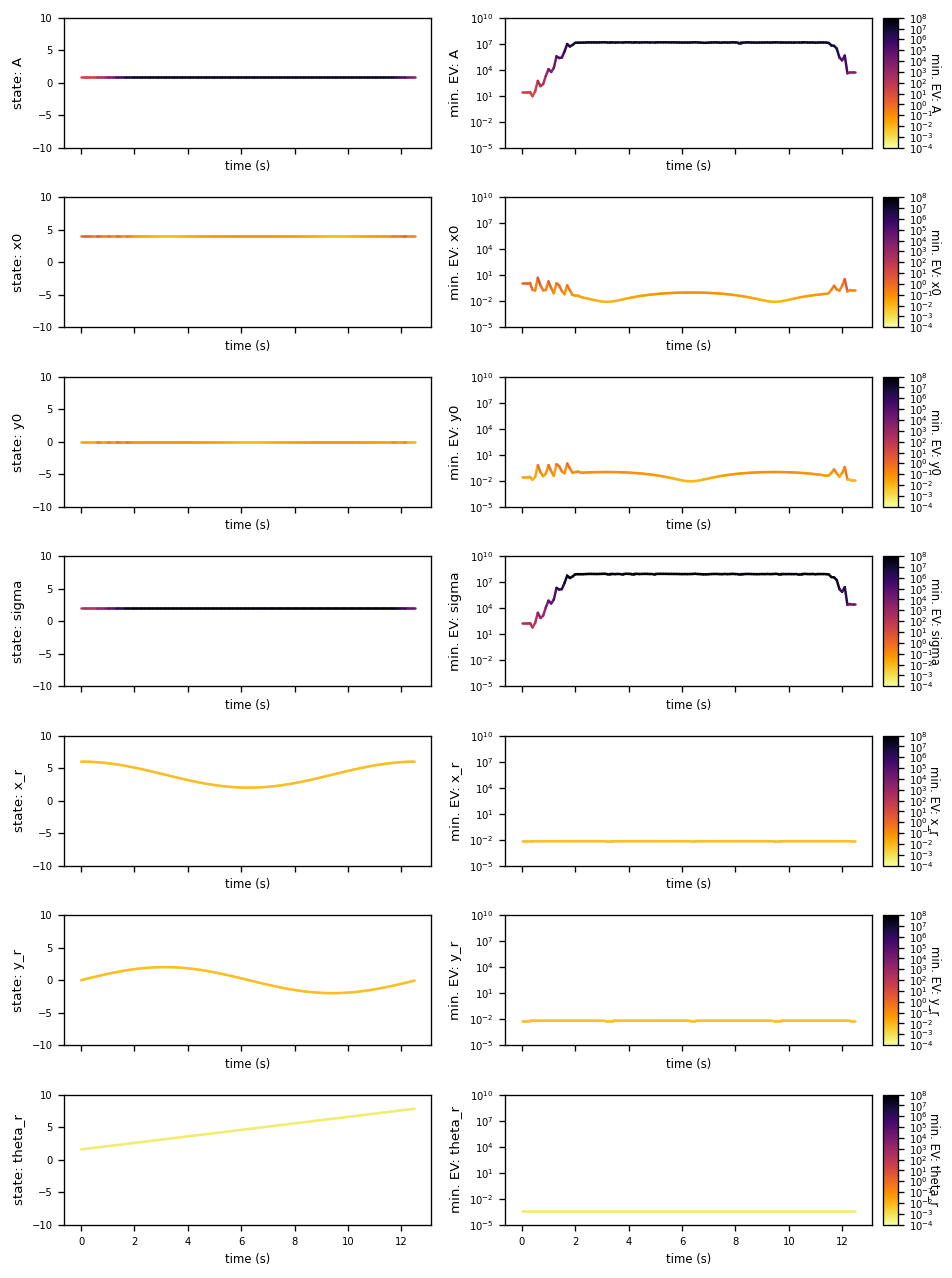

In [17]:
# pull out minimum error variance
EV_aligned = SFO.get_minimum_error_variance()

EV_no_nan = EV_aligned.fillna(method='bfill').fillna(method='ffill')

x_sim_df = pd.DataFrame(x_sim)
u_sim_df = pd.DataFrame(u_sim)
y_sim_df = pd.DataFrame(y_sim)

states = list(SFO.FO[0].O.columns)
n_state = len(states)

fig, ax = plt.subplots(n_state, 2, figsize=(8, n_state*1.6), dpi=120, sharex=True)
ax = np.atleast_2d(ax)

cmap = 'inferno_r'
min_ev = np.nanmin(EV_no_nan.iloc[:, 2:].values)
max_ev = np.nanmax(EV_no_nan.iloc[:, 2:].values)

log_tick_low = int(np.floor(np.log10(min_ev)))
log_tick_high = int(np.ceil(np.log10(max_ev)))
cnorm = mpl.colors.LogNorm(vmin=10**log_tick_low, vmax=10**log_tick_high)

for n, state_name in enumerate(states):
    pybounds.colorline(SEOM.t_sim, x_sim_df[state_name].values, EV_no_nan[state_name].values,
                           ax=ax[n, 0], cmap=cmap, norm=cnorm)
    pybounds.colorline(SEOM.t_sim, EV_no_nan[state_name].values, EV_no_nan[state_name].values,
                           ax=ax[n, 1], cmap=cmap, norm=cnorm)
    # colorbar
    cax = ax[n, -1].inset_axes([1.03, 0.0, 0.04, 1.0])
    cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=cnorm, cmap=cmap), cax=cax,
                        ticks=np.logspace(log_tick_low, log_tick_high, log_tick_high-log_tick_low + 1))
    cbar.set_label('min. EV: ' + state_name, rotation=270, fontsize=7)
    cbar.ax.tick_params(labelsize=6)

    ax[n, 0].set_ylim(-10, 10)
    ax[n, 1].set_ylim(1e-5, 1e10)
    ax[n, 0].set_ylabel('state: ' + state_name, fontsize=8)
    ax[n, 1].set_yscale('log')
    ax[n, 1].set_ylabel('min. EV: ' + state_name, fontsize=8)

for a in ax.flat:
    a.tick_params(axis='both', labelsize=6)
    a.set_xlabel('time (s)', fontsize=7)
    offset = t_sim[-1] * 0.05
    a.set_xlim(-offset, t_sim[-1] + offset)

fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=0.4)
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()

# median_evs = {s: np.nanmedian(EV_no_nan[s].values) for s in states}
# print("Median minimum error variance (per state):")
# for s, val in median_evs.items():
#     print(f"  {s}: {val:.3e}")

In [18]:
import sys
import requests
import importlib

def import_local_or_github(package_name, function_name=None, directory=None, giturl=None):
    # Import functions directly from github
    # Important: note that we use raw.githubusercontent.com, not github.com

    try: # to find the file locally
        if directory is not None:
            if directory not in sys.path:
                sys.path.append(directory)

        package = importlib.import_module(package_name)
        if function_name is not None:
            function = getattr(package, function_name)
            return function
        else:
            return package

    except: # get the file from github
        if giturl is None:
            giturl = 'https://raw.githubusercontent.com/florisvb/Nonlinear_and_Data_Driven_Estimation/main/Utility/' + str(package_name) + '.py'

        r = requests.get(giturl)
        print('Fetching from: ')
        print(r)

        # Store the file to the colab working directory
        with open(package_name+'.py', 'w') as f:
            f.write(r.text)
        f.close()

        # import the function we want from that file
        package = importlib.import_module(package_name)
        if function_name is not None:
            function = getattr(package , function_name)
            return function
        else:
            return package

extended_kalman_filter = import_local_or_github('extended_kalman_filter', directory='../Utility')

Fetching from:  <Response [200]>


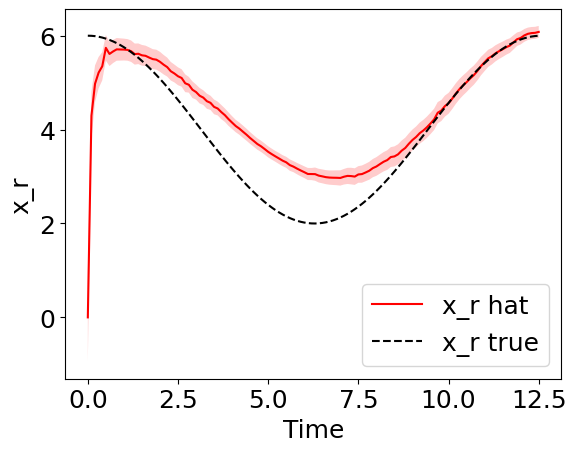

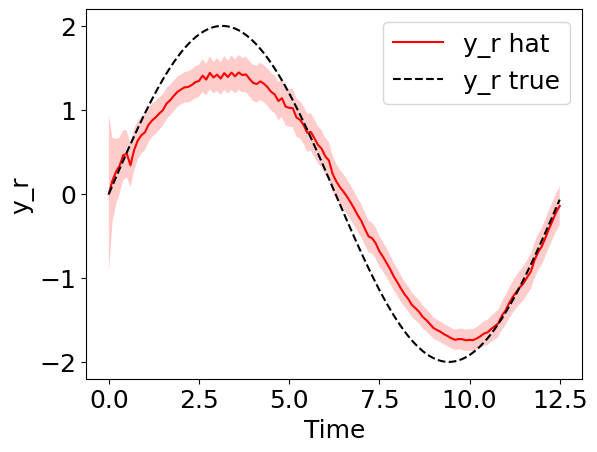

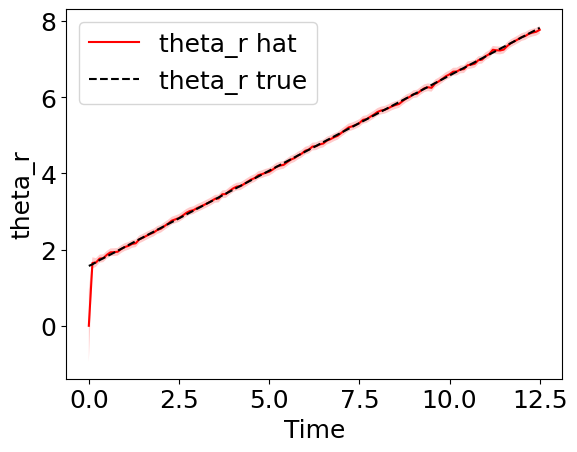

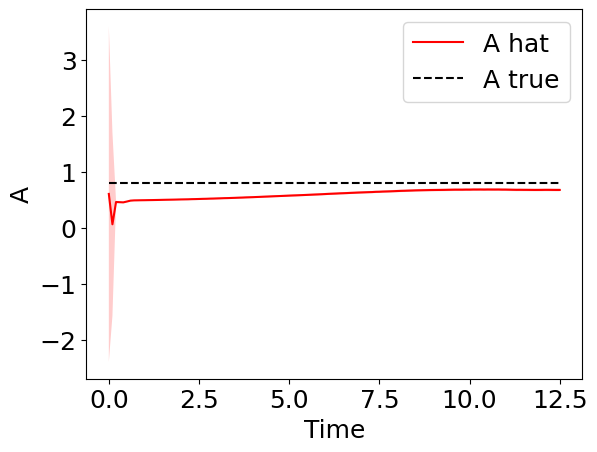

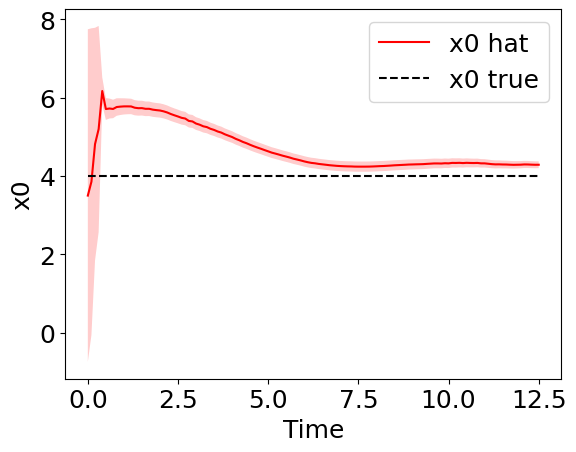

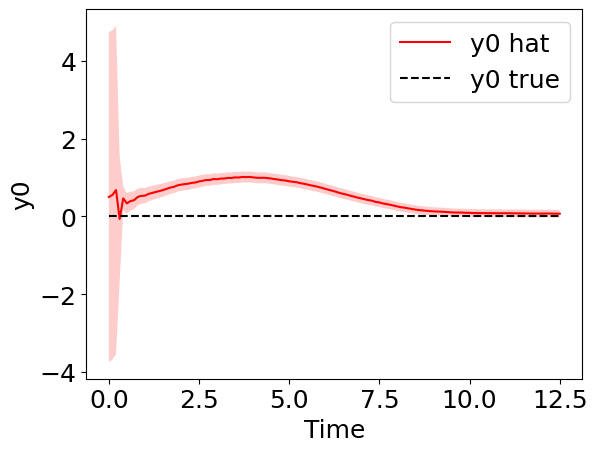

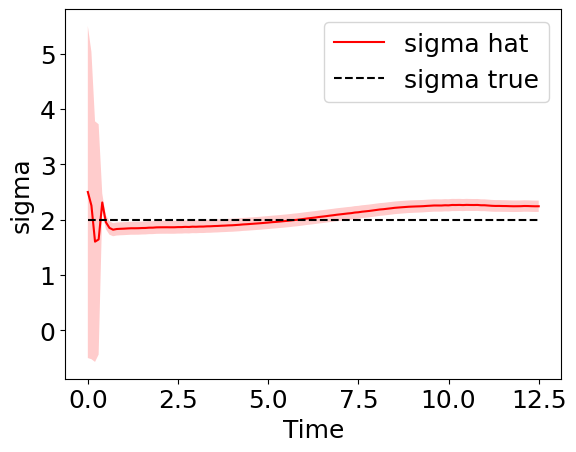


EKF Estimation Summary

Final Estimates vs True Values:
A       : True=  0.800, Est=  0.671, Error= -0.129, StdDev=  0.008
x0      : True=  4.000, Est=  4.287, Error=  0.287, StdDev=  0.029
y0      : True=  0.000, Est=  0.070, Error=  0.070, StdDev=  0.032
sigma   : True=  2.000, Est=  2.242, Error=  0.242, StdDev=  0.034
x_r     : True=  5.999, Est=  6.081, Error=  0.082, StdDev=  0.042
y_r     : True= -0.068, Est= -0.143, Error= -0.075, StdDev=  0.075
theta_r : True=  7.820, Est=  7.770, Error= -0.051, StdDev=  0.034



In [19]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pybounds

# Import or define extended_kalman_filter
# Assuming you have the extended_kalman_filter module available
try:
    from extended_kalman_filter import EKF
except:
    print("Warning: extended_kalman_filter module not found. You may need to import it from the github utility.")

# # Parameters (from your system)
# params = dict(
#     # Robot physical params
#     m=20.0, kv=300.0, bv=20.0, Iz=1.0, kw=50.0, bw=2.0,
#     # field parameters (real, for purposes of simulation)
#     A_true=0.8, x0_true=4.0, y0_true=0.0, sigma_true=2.0,
#     soil_type=1.0,
#     force_alpha=500.0,
#     force_beta=200.0,
#     # measurement noise (stddev)
#     noise_pose_xy=0.2,
#     noise_pose_theta=0.05,
#     noise_moisture=0.02,
#     noise_force=0.4
# )

# # Dynamics function
# def f(x, u):
#     """
#     State dynamics: x = [A, x0, y0, sigma, x_r, y_r, theta_r]
#     Control: u = [v, w]
#     """
#     if x is None:
#         return None
#     if u is None:
#         u = [0.0, 0.0]

#     v, w = u
#     A, x0, y0, sigma, x_r, y_r, theta_r = x

#     # Static field parameters
#     dA = 0.0
#     dx0 = 0.0
#     dy0 = 0.0
#     dsigma = 0.0

#     # Unicycle kinematics for robot pose
#     dx_r = v * np.cos(theta_r)
#     dy_r = v * np.sin(theta_r)
#     dtheta = w

#     return np.array([dA, dx0, dy0, dsigma, dx_r, dy_r, dtheta])

# # Measurement model
# def g_m_from_state(x):
#     """Return moisture value at robot position"""
#     A, x0, y0, sigma, x_r, y_r, theta_r = x
#     sigma_eff = sigma if sigma > 1e-6 else 1e-6
#     m_val = A * np.exp(-((x_r - x0)**2 + (y_r - y0)**2) / (2.0 * sigma_eff**2))
#     return m_val

# def force_model(m_local, soil_type=params['soil_type']):
#     """Force model based on local moisture"""
#     alpha = params['force_alpha']
#     beta = params['force_beta']
#     F = soil_type * (alpha * (1.0 - m_local) + beta * (1.0 - m_local)**2)
#     return F

# def h(x, u):
#     """
#     Measurement function: y = [x_r, y_r, theta_r, z_m, z_f]
#     """
#     if x is None:
#         return None

#     A, x0, y0, sigma, x_r, y_r, theta_r = x

#     # Pose measurements
#     x_r_meas = x_r
#     y_r_meas = y_r
#     theta_meas = theta_r

#     # Environmental measurements
#     m_local = g_m_from_state(x)
#     z_m = m_local

#     # Force measurement
#     z_f = force_model(m_local)

#     return np.array([x_r_meas, y_r_meas, theta_meas, z_m, z_f])

# # State and measurement names
# state_names = ['A', 'x0', 'y0', 'sigma', 'x_r', 'y_r', 'theta_r']
# input_names = ['v', 'w']
# measurement_names = ['x_r', 'y_r', 'theta_r', 'z_m', 'z_f']

# # Simulation parameters
# dt = 0.1
# tsim = np.arange(0, 8.0, step=dt)

# # Create simulator
# simulator = pybounds.Simulator(f, h, dt=dt, state_names=state_names,
#                                input_names=input_names, measurement_names=measurement_names,
#                                mpc_horizon=10)

# # True initial states
# x0_true = [
#     params['A_true'],
#     params['x0_true'],
#     params['y0_true'],
#     params['sigma_true'],
#     0.0,  # x_r initial
#     0.0,  # y_r initial
#     0.0   # theta_r initial
# ]

# # Setpoint for MPC
# setpoint = {
#     'x_r': tsim,
#     'y_r': np.sin(tsim),
# }
# simulator.update_dict(setpoint, name='setpoint')

# # MPC objective
# cost_x = (simulator.model.x['x_r'] - simulator.model.tvp['x_r_set']) ** 2
# cost_y = (simulator.model.x['y_r'] - simulator.model.tvp['y_r_set']) ** 2
# cost = cost_x + cost_y
# simulator.mpc.set_objective(mterm=cost, lterm=cost)
# simulator.mpc.set_rterm(v=1e-4, w=1e-4)

# # Input bounds
# simulator.mpc.bounds['upper', '_u', 'v'] = 1.5
# simulator.mpc.bounds['lower', '_u', 'v'] = -1.5
# simulator.mpc.bounds['upper', '_u', 'w'] = 0.8
# simulator.mpc.bounds['lower', '_u', 'w'] = -0.8

# # Run simulation
# t_sim, x_sim, u_sim, y_sim = simulator.simulate(x0=x0_true, u=None, mpc=True, return_full_output=True)

# # Add measurement noise
# measurement_noise_stds = {
#     'x_r': params['noise_pose_xy'],
#     'y_r': params['noise_pose_xy'],
#     'theta_r': params['noise_pose_theta'],
#     'z_m': params['noise_moisture'],
#     'z_f': params['noise_force'],
# }

# y_noisy = {key: y_sim[key] + np.random.normal(0, measurement_noise_stds[key], len(y_sim[key]))
#            for key in y_sim.keys()}

# # Convert to dataframes
# y_noisy_df = pd.DataFrame(y_noisy)
# u_sim_df = pd.DataFrame(u_sim)
# x_sim_df = pd.DataFrame(x_sim)

# print("Simulation complete. Starting EKF...")

# =============================================================================
# Extended Kalman Filter Setup
# =============================================================================

# Initial state guess (perturbed from true values)
x0_guess = np.array([
    0.6,   # A guess
    3.5,   # x0 guess
    0.5,   # y0 guess
    2.5,   # sigma guess
    0.0,   # x_r (known)
    0.0,   # y_r (known)
    0.0    # theta_r (known)
])

# Initial controls
u0 = np.zeros(2)

# Initial error covariance - larger for uncertain field parameters
P0 = np.diag([1.0, 2.0, 2.0, 1.0, 0.1, 0.1, 0.1])

# Measurement covariance matrix (from noise stds)
R = np.diag([measurement_noise_stds[key]**2 for key in measurement_names])

# Process covariance - field parameters are static, robot pose varies
Q = np.diag([1e-6, 1e-6, 1e-6, 1e-6, 1e-3, 1e-3, 1e-3])

# Create EKF
EKF = EKF(f, h, x0_guess, u0, P0, Q, R,
          dynamics_type='continuous',
          discretization_timestep=dt,
          circular_measurements=(0,0,1,0,0))  # theta_r is circular

# Run EKF estimation
EKF.estimate(y_noisy_df, u_sim_df)

# Package results
x_est = pd.DataFrame(np.vstack(EKF.history['X']), columns=state_names)
P_diags = np.vstack([EKF.history['P_diags'][i] for i in range(len(EKF.history['P_diags']))])
P_diags = pd.DataFrame(P_diags, columns=state_names)

try:
    from plot_utility import plot_tme
except:
    import sys
    import requests
    import importlib

    def import_local_or_github(package_name, function_name=None, directory=None, giturl=None):
        try:
            if directory is not None:
                if directory not in sys.path:
                    sys.path.append(directory)
            package = importlib.import_module(package_name)
            if function_name is not None:
                function = getattr(package, function_name)
                return function
            else:
                return package
        except:
            if giturl is None:
                giturl = 'https://raw.githubusercontent.com/florisvb/Nonlinear_and_Data_Driven_Estimation/main/Utility/' + str(package_name) + '.py'
            r = requests.get(giturl)
            print('Fetching from: ', r)
            with open(package_name+'.py', 'w') as f:
                f.write(r.text)
            f.close()
            package = importlib.import_module(package_name)
            if function_name is not None:
                function = getattr(package, function_name)
                return function
            else:
                return package

    plot_tme = import_local_or_github('plot_utility', 'plot_tme')

# Plot robot position x_r with 3-sigma bounds
fig = plt.figure()
ax = fig.add_subplot(111)
plot_tme(t_sim, x_sim_df['x_r'], None, x_est['x_r'], label_var='x_r', ax=ax)
plus3sigma = x_est['x_r'] + 3*np.sqrt(P_diags['x_r'])
minus3sigma = x_est['x_r'] - 3*np.sqrt(P_diags['x_r'])
ax.fill_between(t_sim, plus3sigma, minus3sigma, facecolor='red', edgecolor='none', alpha=0.2)

# Plot robot position y_r with 3-sigma bounds
fig = plt.figure()
ax = fig.add_subplot(111)
plot_tme(t_sim, x_sim_df['y_r'], None, x_est['y_r'], label_var='y_r', ax=ax)
plus3sigma = x_est['y_r'] + 3*np.sqrt(P_diags['y_r'])
minus3sigma = x_est['y_r'] - 3*np.sqrt(P_diags['y_r'])
ax.fill_between(t_sim, plus3sigma, minus3sigma, facecolor='red', edgecolor='none', alpha=0.2)

# Plot robot heading theta_r with 3-sigma bounds
fig = plt.figure()
ax = fig.add_subplot(111)
plot_tme(t_sim, x_sim_df['theta_r'], None, x_est['theta_r'], label_var='theta_r', ax=ax)
plus3sigma = x_est['theta_r'] + 3*np.sqrt(P_diags['theta_r'])
minus3sigma = x_est['theta_r'] - 3*np.sqrt(P_diags['theta_r'])
ax.fill_between(t_sim, plus3sigma, minus3sigma, facecolor='red', edgecolor='none', alpha=0.2)

# Plot field parameter A with 3-sigma bounds
fig = plt.figure()
ax = fig.add_subplot(111)
plot_tme(t_sim, x_sim_df['A'], None, x_est['A'], label_var='A', ax=ax)
plus3sigma = x_est['A'] + 3*np.sqrt(P_diags['A'])
minus3sigma = x_est['A'] - 3*np.sqrt(P_diags['A'])
ax.fill_between(t_sim, plus3sigma, minus3sigma, facecolor='red', edgecolor='none', alpha=0.2)

# Plot field parameter x0 with 3-sigma bounds
fig = plt.figure()
ax = fig.add_subplot(111)
plot_tme(t_sim, x_sim_df['x0'], None, x_est['x0'], label_var='x0', ax=ax)
plus3sigma = x_est['x0'] + 3*np.sqrt(P_diags['x0'])
minus3sigma = x_est['x0'] - 3*np.sqrt(P_diags['x0'])
ax.fill_between(t_sim, plus3sigma, minus3sigma, facecolor='red', edgecolor='none', alpha=0.2)

# Plot field parameter y0 with 3-sigma bounds
fig = plt.figure()
ax = fig.add_subplot(111)
plot_tme(t_sim, x_sim_df['y0'], None, x_est['y0'], label_var='y0', ax=ax)
plus3sigma = x_est['y0'] + 3*np.sqrt(P_diags['y0'])
minus3sigma = x_est['y0'] - 3*np.sqrt(P_diags['y0'])
ax.fill_between(t_sim, plus3sigma, minus3sigma, facecolor='red', edgecolor='none', alpha=0.2)

# Plot field parameter sigma with 3-sigma bounds
fig = plt.figure()
ax = fig.add_subplot(111)
plot_tme(t_sim, x_sim_df['sigma'], None, x_est['sigma'], label_var='sigma', ax=ax)
plus3sigma = x_est['sigma'] + 3*np.sqrt(P_diags['sigma'])
minus3sigma = x_est['sigma'] - 3*np.sqrt(P_diags['sigma'])
ax.fill_between(t_sim, plus3sigma, minus3sigma, facecolor='red', edgecolor='none', alpha=0.2)

plt.show()

# Summary statistics
print("\n" + "="*60)
print("EKF Estimation Summary")
print("="*60)
print("\nFinal Estimates vs True Values:")
for state in state_names:
    true_val = x_sim_df[state].iloc[-1]
    est_val = x_est[state].iloc[-1]
    error = est_val - true_val
    std_dev = np.sqrt(P_diags[state].iloc[-1])
    print(f"{state:8s}: True={true_val:7.3f}, Est={est_val:7.3f}, Error={error:7.3f}, StdDev={std_dev:7.3f}")

print("\n" + "="*60)

Fetching from:  <Response [200]>
Running UKF estimation...


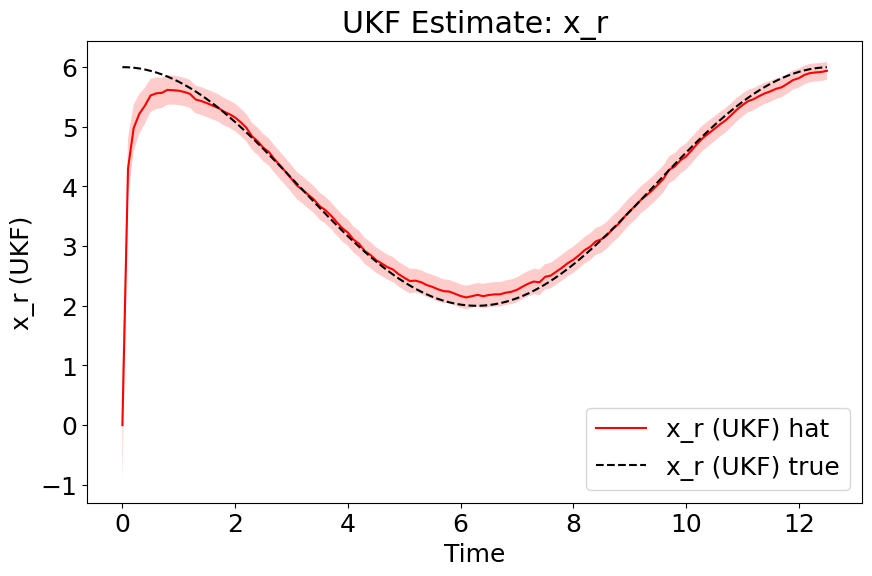

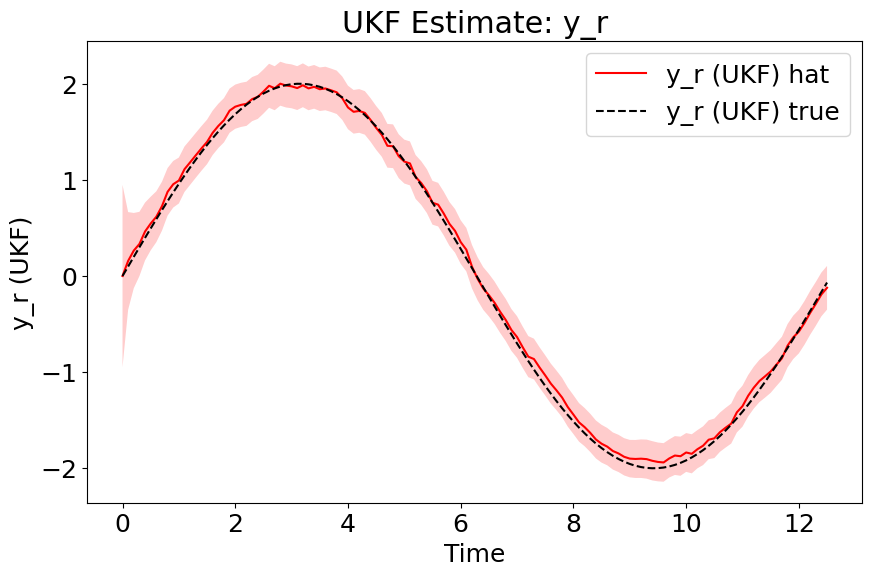

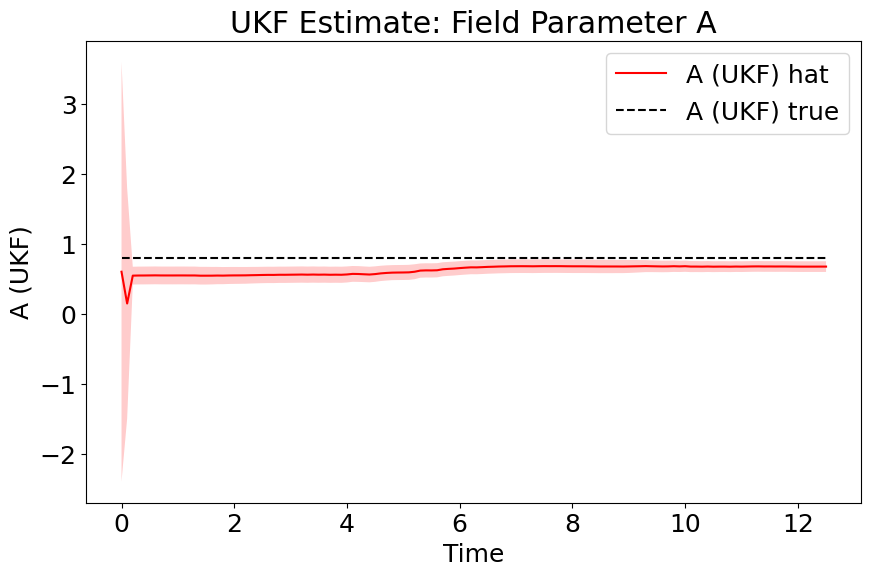

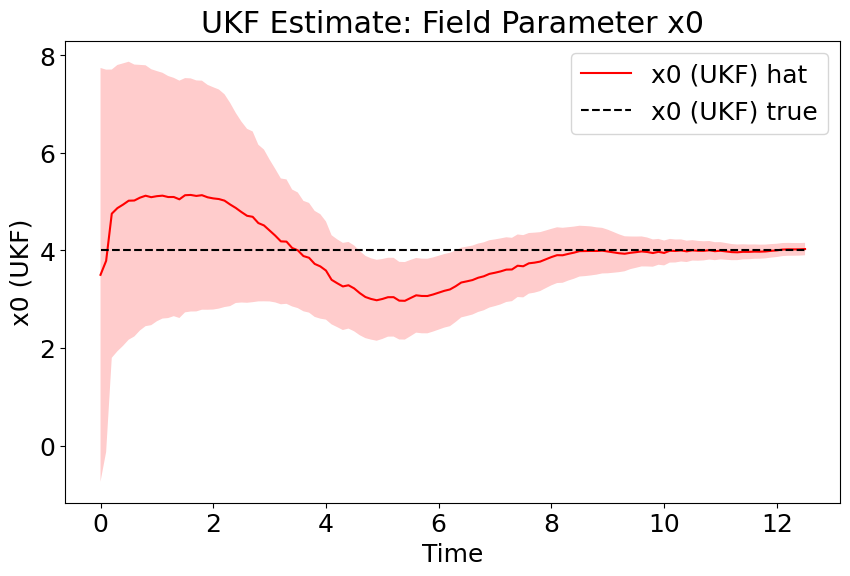

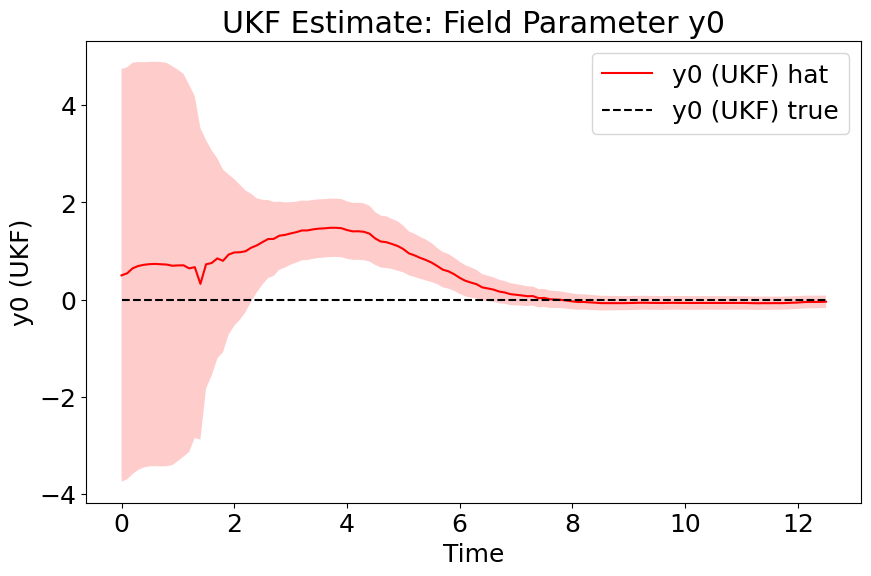

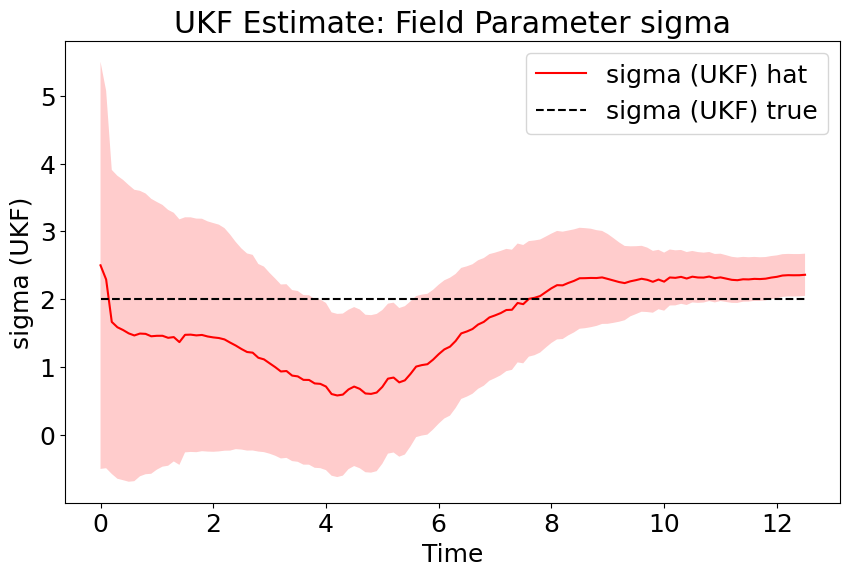

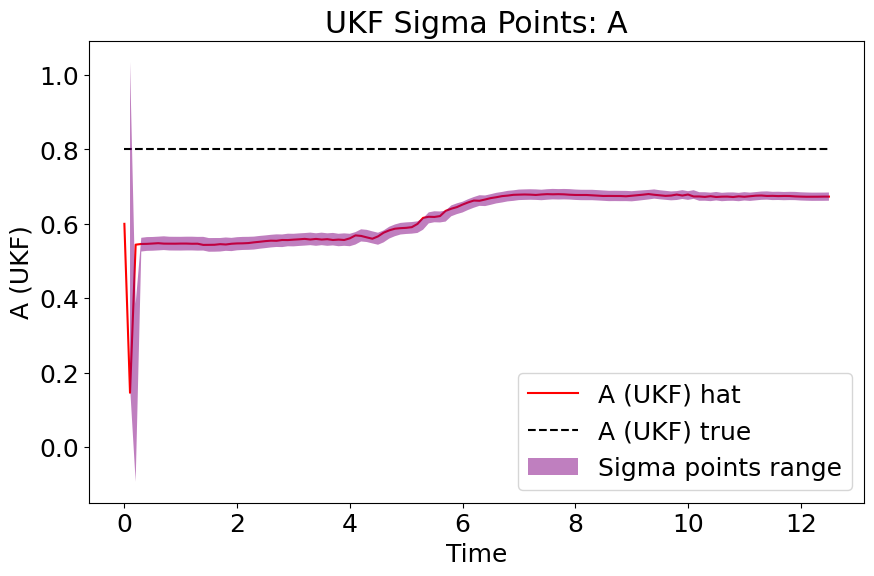

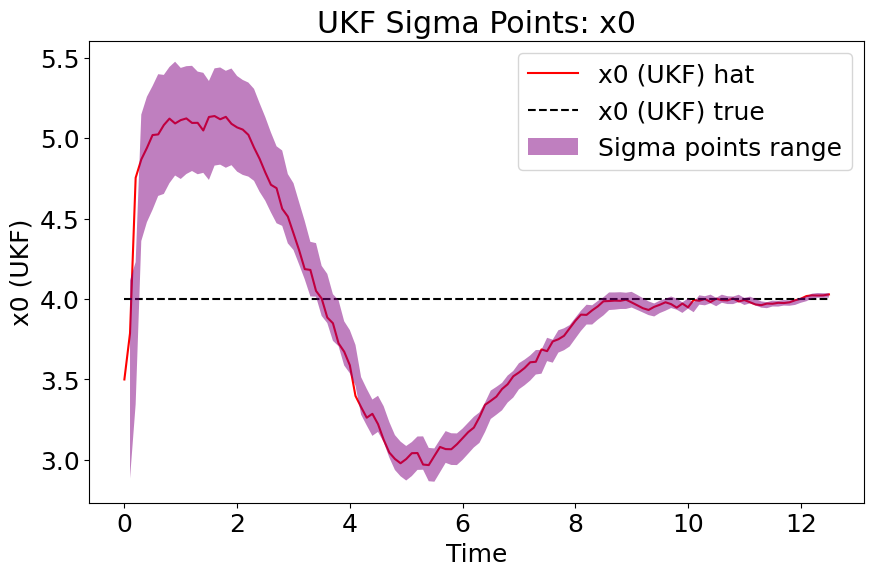

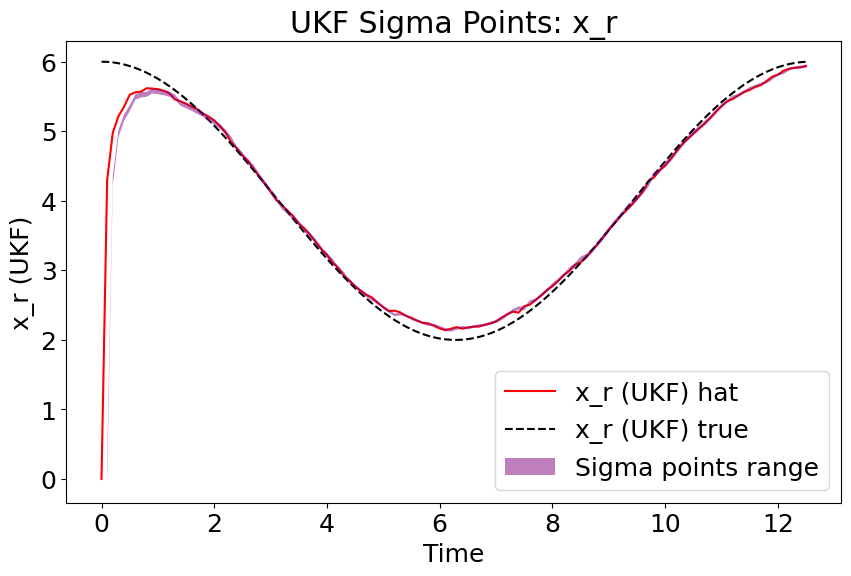


UKF Estimation Summary

Final Estimates vs True Values:
A       : True=  0.800, Est=  0.673, Error= -0.127, StdDev=  0.025
x0      : True=  4.000, Est=  4.029, Error=  0.029, StdDev=  0.043
y0      : True=  0.000, Est= -0.042, Error= -0.042, StdDev=  0.043
sigma   : True=  2.000, Est=  2.360, Error=  0.360, StdDev=  0.104
x_r     : True=  5.999, Est=  5.940, Error= -0.059, StdDev=  0.050
y_r     : True= -0.068, Est= -0.122, Error= -0.054, StdDev=  0.076
theta_r : True=  7.820, Est=  7.771, Error= -0.050, StdDev=  0.034


EKF vs UKF Comparison (Final Errors)
A       : EKF Error=  0.129, UKF Error=  0.127
x0      : EKF Error=  0.287, UKF Error=  0.029
y0      : EKF Error=  0.070, UKF Error=  0.042
sigma   : EKF Error=  0.242, UKF Error=  0.360
x_r     : EKF Error=  0.082, UKF Error=  0.059
y_r     : EKF Error=  0.075, UKF Error=  0.054
theta_r : EKF Error=  0.051, UKF Error=  0.050


In [20]:
try:
    import unscented_kalman_filter
except:
    unscented_kalman_filter = import_local_or_github('unscented_kalman_filter', directory='../Utility')

# Use the same initial conditions as EKF
x0_ukf = np.array([
    0.6,   # A guess
    3.5,   # x0 guess
    0.5,   # y0 guess
    2.5,   # sigma guess
    0.0,   # x_r (known)
    0.0,   # y_r (known)
    0.0    # theta_r (known)
])

u0_ukf = np.zeros(2)

# Same covariance matrices as EKF
P0_ukf = np.diag([1.0, 2.0, 2.0, 1.0, 0.1, 0.1, 0.1])
Q_ukf = np.diag([1e-6, 1e-6, 1e-6, 1e-6, 1e-3, 1e-3, 1e-3])
R_ukf = np.diag([measurement_noise_stds[key]**2 for key in measurement_names])

# Create UKF
UKF = unscented_kalman_filter.UKF(f, h, x0_ukf, u0_ukf, P0_ukf, Q_ukf, R_ukf,
                                   dynamics_type='continuous',
                                   discretization_timestep=dt,
                                   alpha=0.1)

print("Running UKF estimation...")
UKF.estimate(y_noisy_df, u_sim_df)

# Package UKF results
x_est_ukf = pd.DataFrame(np.vstack(UKF.history['X']), columns=state_names)

# Covariance diagonals
P_diags_ukf = np.vstack([np.diag(UKF.history['P'][i]) for i in range(len(UKF.history['P']))])
P_diags_ukf = pd.DataFrame(P_diags_ukf, columns=state_names)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
plot_tme(t_sim, x_sim_df['x_r'], None, x_est_ukf['x_r'], label_var='x_r (UKF)', ax=ax)
plus3sigma = x_est_ukf['x_r'] + 3*np.sqrt(P_diags_ukf['x_r'])
minus3sigma = x_est_ukf['x_r'] - 3*np.sqrt(P_diags_ukf['x_r'])
ax.fill_between(t_sim, plus3sigma, minus3sigma, facecolor='red', edgecolor='none', alpha=0.2)
ax.set_title('UKF Estimate: x_r')

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
plot_tme(t_sim, x_sim_df['y_r'], None, x_est_ukf['y_r'], label_var='y_r (UKF)', ax=ax)
plus3sigma = x_est_ukf['y_r'] + 3*np.sqrt(P_diags_ukf['y_r'])
minus3sigma = x_est_ukf['y_r'] - 3*np.sqrt(P_diags_ukf['y_r'])
ax.fill_between(t_sim, plus3sigma, minus3sigma, facecolor='red', edgecolor='none', alpha=0.2)
ax.set_title('UKF Estimate: y_r')

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
plot_tme(t_sim, x_sim_df['A'], None, x_est_ukf['A'], label_var='A (UKF)', ax=ax)
plus3sigma = x_est_ukf['A'] + 3*np.sqrt(P_diags_ukf['A'])
minus3sigma = x_est_ukf['A'] - 3*np.sqrt(P_diags_ukf['A'])
ax.fill_between(t_sim, plus3sigma, minus3sigma, facecolor='red', edgecolor='none', alpha=0.2)
ax.set_title('UKF Estimate: Field Parameter A')

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
plot_tme(t_sim, x_sim_df['x0'], None, x_est_ukf['x0'], label_var='x0 (UKF)', ax=ax)
plus3sigma = x_est_ukf['x0'] + 3*np.sqrt(P_diags_ukf['x0'])
minus3sigma = x_est_ukf['x0'] - 3*np.sqrt(P_diags_ukf['x0'])
ax.fill_between(t_sim, plus3sigma, minus3sigma, facecolor='red', edgecolor='none', alpha=0.2)
ax.set_title('UKF Estimate: Field Parameter x0')

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
plot_tme(t_sim, x_sim_df['y0'], None, x_est_ukf['y0'], label_var='y0 (UKF)', ax=ax)
plus3sigma = x_est_ukf['y0'] + 3*np.sqrt(P_diags_ukf['y0'])
minus3sigma = x_est_ukf['y0'] - 3*np.sqrt(P_diags_ukf['y0'])
ax.fill_between(t_sim, plus3sigma, minus3sigma, facecolor='red', edgecolor='none', alpha=0.2)
ax.set_title('UKF Estimate: Field Parameter y0')

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
plot_tme(t_sim, x_sim_df['sigma'], None, x_est_ukf['sigma'], label_var='sigma (UKF)', ax=ax)
plus3sigma = x_est_ukf['sigma'] + 3*np.sqrt(P_diags_ukf['sigma'])
minus3sigma = x_est_ukf['sigma'] - 3*np.sqrt(P_diags_ukf['sigma'])
ax.fill_between(t_sim, plus3sigma, minus3sigma, facecolor='red', edgecolor='none', alpha=0.2)
ax.set_title('UKF Estimate: Field Parameter sigma')

# Looking at sigma points

# Plot sigma points for field parameter A
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
state = 'A'
plot_tme(t_sim, x_sim_df[state], None, x_est_ukf[state], label_var=state + ' (UKF)', ax=ax)
state_ix = state_names.index(state)
sigma_lo = UKF.history['sigma_points'][state_ix, 0, :]
sigma_hi = UKF.history['sigma_points'][state_ix, -1, :]
ax.fill_between(t_sim[1:], sigma_lo, sigma_hi, facecolor='purple', edgecolor='none', alpha=0.5, zorder=100, label='Sigma points range')
ax.set_title(f'UKF Sigma Points: {state}')
ax.legend()

# Plot sigma points for field parameter x0
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
state = 'x0'
plot_tme(t_sim, x_sim_df[state], None, x_est_ukf[state], label_var=state + ' (UKF)', ax=ax)
state_ix = state_names.index(state)
sigma_lo = UKF.history['sigma_points'][state_ix, 0, :]
sigma_hi = UKF.history['sigma_points'][state_ix, -1, :]
ax.fill_between(t_sim[1:], sigma_lo, sigma_hi, facecolor='purple', edgecolor='none', alpha=0.5, zorder=100, label='Sigma points range')
ax.set_title(f'UKF Sigma Points: {state}')
ax.legend()

# Plot sigma points for robot position x_r
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
state = 'x_r'
plot_tme(t_sim, x_sim_df[state], None, x_est_ukf[state], label_var=state + ' (UKF)', ax=ax)
state_ix = state_names.index(state)
sigma_lo = UKF.history['sigma_points'][state_ix, 0, :]
sigma_hi = UKF.history['sigma_points'][state_ix, -1, :]
ax.fill_between(t_sim[1:], sigma_lo, sigma_hi, facecolor='purple', edgecolor='none', alpha=0.5, zorder=100, label='Sigma points range')
ax.set_title(f'UKF Sigma Points: {state}')
ax.legend()

plt.show()

# Summary statistics for UKF
print("\n" + "="*60)
print("UKF Estimation Summary")
print("="*60)
print("\nFinal Estimates vs True Values:")
for state in state_names:
    true_val = x_sim_df[state].iloc[-1]
    est_val = x_est_ukf[state].iloc[-1]
    error = est_val - true_val
    std_dev = np.sqrt(P_diags_ukf[state].iloc[-1])
    print(f"{state:8s}: True={true_val:7.3f}, Est={est_val:7.3f}, Error={error:7.3f}, StdDev={std_dev:7.3f}")

print("\n" + "="*60)

# Optional: Compare EKF vs UKF performance
print("\n" + "="*60)
print("EKF vs UKF Comparison (Final Errors)")
print("="*60)
for state in state_names:
    true_val = x_sim_df[state].iloc[-1]
    ekf_error = abs(x_est[state].iloc[-1] - true_val)
    ukf_error = abs(x_est_ukf[state].iloc[-1] - true_val)
    print(f"{state:8s}: EKF Error={ekf_error:7.3f}, UKF Error={ukf_error:7.3f}")
print("="*60)